### Environment Setup
This section installs all the necessary dependencies required for the notebook. These libraries include tools for natural language processing, dataset management, and statistical analysis. If you already have a compatible environment, you can skip this step.

In [1]:
# Install dependencies (same as the env file, so you may wish to skip this if running locally / with persistent conda environment)
%pip install transformers
%pip install accelerate
%pip install bitsandbytes
%pip install pyDOE3
%pip install datasets
%pip install torch
%pip install jinja2
%pip install torchmetrics
%pip install tqdm
%pip install jupyter
%pip install pretty-jupyter
%pip install researchpy
%pip install statsmodels
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Library Imports
Here, we import the essential Python libraries and modules that will be used throughout the notebook. These include:
- `transformers` and `datasets` for natural language processing tasks.
- `pyDOE3` for design of experiments.
- `torchmetrics` for evaluation metrics.
- `jinja2` for templating.
- `statsmodels` for statistical modeling.

In [2]:
import pandas as pd
import csv
import tqdm
import time
import os
import jinja2
import textwrap
import datasets

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from pyDOE3 import *
from torchmetrics.text.rouge import ROUGEScore

import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt

import re  # Import regular expression module


### ROUGE Scores and Their Relevance

#### **ROUGE-1**
- **Definition**: Measures the overlap of unigrams (single words) between the candidate (rewritten) text and the reference (original) text.
- **Relevance**: 
  - High **recall** ensures that all key words from the original text are retained in the rewritten version.
  - High **precision** indicates that the rewritten text avoids including unnecessary words not present in the original.
  - **F-Measure** balances precision and recall to provide an overall alignment score.

---

#### **ROUGE-2**
- **Definition**: Measures the overlap of bigrams (two consecutive words) between the candidate and reference text.
- **Relevance**:
  - High **recall** ensures the rewritten text preserves phrasing and contextual meaning from the original.
  - High **precision** confirms that the word pairings are concise and relevant to the original.
  - **F-Measure** assesses the overall similarity in phrasing and flow between the texts.

---

#### **ROUGE-L**
- **Definition**: Evaluates the longest common subsequence (LCS) between the candidate and reference text.
- **Relevance**:
  - High **recall** indicates the rewritten text maintains the sequence and structure of the original.
  - High **precision** ensures that the sequence includes no extraneous content.
  - **F-Measure** provides a balanced metric for assessing structural and sequential fidelity.

---

#### **ROUGE-Lsum**
- **Definition**: Extends ROUGE-L to multi-sentence or paragraph-level comparisons by analyzing the longest common subsequence across text segments.
- **Relevance**:
  - Ensures that the overall structure, coherence, and flow of the rewritten text are consistent with the original at a broader level.
  - Useful for tasks involving longer passages or summaries.

---

These scores collectively evaluate how well the rewritten text adheres to the original, balancing precision (conciseness) and recall (completeness) to ensure the meaning is preserved without unnecessary additions.

In [3]:
df = pd.read_csv("./output.csv", delimiter='§', engine='python')
df = df.fillna(16)
df

,model,batch_size,max_new_tokens,input,raw,output,trimmed_output,score,start_time,end_time,time_taken,quantization
0,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"[' I darted diagonally through the street, reg...","{'rouge1_fmeasure': tensor(0.8250), 'rouge1_pr...",1.732998e+09,1.732998e+09,6.452672,4.0
1,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['If there were any suggestions of Mendelssohn...,['Instruction: Rewrite the given text while ke...,[' If there were any suggestions of Mendelssoh...,"{'rouge1_fmeasure': tensor(0.7968), 'rouge1_pr...",1.732998e+09,1.732998e+09,4.511077,4.0
2,meta-llama/Llama-3.2-1B,1,100,"[""Instruction: Rewrite the given text while ke...","[""Deep Tissue Massage is a form of bodywork th...","[""Instruction: Rewrite the given text while ke...","["" Deep Tissue Massage is a form of bodywork t...","{'rouge1_fmeasure': tensor(0.7449), 'rouge1_pr...",1.732998e+09,1.732998e+09,4.376606,4.0
3,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['The procedure for constructing your resume a...,['Instruction: Rewrite the given text while ke...,['1. A procedure for generating a resume and e...,"{'rouge1_fmeasure': tensor(0.7918), 'rouge1_pr...",1.732998e+09,1.732998e+09,4.437645,4.0
4,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['A. Action of the Board: The Board upon a fin...,['Instruction: Rewrite the given text while ke...,[' A. Action of the Board: The Board upon a fi...,"{'rouge1_fmeasure': tensor(0.8115), 'rouge1_pr...",1.732998e+09,1.732998e+09,4.466196,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
400,meta-llama/Llama-3.2-1B,8,500,['Instruction: Rewrite the given text while ke...,['The culture takes its name from the village ...,['Instruction: Rewrite the given text while ke...,"['5,000 BCE – 4,000 BCE; 4,000 BCE – 3,000 BCE...","{'rouge1_fmeasure': tensor(0.5521), 'rouge1_pr...",1.733010e+09,1.733010e+09,32.459341,16.0
401,meta-llama/Llama-3.2-3B,8,500,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"['', '1. 2. 3. 4. 5. 6. 7. 8. 9. 10. \n\n ...","{'rouge1_fmeasure': tensor(0.6323), 'rouge1_pr...",1.733010e+09,1.733010e+09,61.150939,16.0
402,meta-llama/Llama-3.2-3B,8,500,['Instruction: Rewrite the given text while ke...,['The culture takes its name from the village ...,['Instruction: Rewrite the given text while ke...,[' The culture takes its name from the village...,"{'rouge1_fmeasure': tensor(0.6989), 'rouge1_pr...",1.733010e+09,1.733010e+09,21.122720,16.0
403,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"['', '', "" Deep Tissue Massage is a kind of bo...","{'rouge1_fmeasure': tensor(0.7471), 'rouge1_pr...",1.733010e+09,1.733010e+09,80.497382,16.0


In [4]:
# Function to safely extract numeric value from a tensor string like 'tensor(0.8250)'
def extract_tensor_value(value):
    """ Extracts the float value from a tensor string like 'tensor(0.8250)' """
    if isinstance(value, str):
        # Replace 'tensor(' and ')' to extract the numeric value
        tensor_match = re.match(r"tensor\(([^)]+)\)", value)
        if tensor_match:
            return float(tensor_match.group(1))
    return value  # Return the value if it's already numeric

# Function to parse the 'score' column and convert it to a dictionary with float values
def parse_score_column(score_str):
    """ Convert the score string to a dictionary with tensor values extracted """
    # First replace tensor-like patterns with numeric values
    score_str = re.sub(r"tensor\(([^)]+)\)", r"\1", score_str)  # Replace 'tensor(x)' with 'x'
    
    # Safely evaluate the dictionary string
    score_dict = eval(score_str)  # This converts the cleaned-up string to a dictionary

    # Convert all values in the dictionary to float if they are tensor-like strings
    for key, value in score_dict.items():
        score_dict[key] = extract_tensor_value(value)
    
    return score_dict

# Apply the function to the 'score' column to convert to dictionaries with float values
df['score'] = df['score'].apply(parse_score_column)

# Now, extract the individual ROUGE metrics and convert them into separate columns
df['rouge1_fmeasure'] = df['score'].apply(lambda x: x['rouge1_fmeasure'])
df['rouge1_precision'] = df['score'].apply(lambda x: x['rouge1_precision'])
df['rouge1_recall'] = df['score'].apply(lambda x: x['rouge1_recall'])
df['rouge2_fmeasure'] = df['score'].apply(lambda x: x['rouge2_fmeasure'])
df['rouge2_precision'] = df['score'].apply(lambda x: x['rouge2_precision'])
df['rouge2_recall'] = df['score'].apply(lambda x: x['rouge2_recall'])
df['rougeL_fmeasure'] = df['score'].apply(lambda x: x['rougeL_fmeasure'])
df['rougeL_precision'] = df['score'].apply(lambda x: x['rougeL_precision'])
df['rougeL_recall'] = df['score'].apply(lambda x: x['rougeL_recall'])
df['rougeLsum_fmeasure'] = df['score'].apply(lambda x: x['rougeLsum_fmeasure'])
df['rougeLsum_precision'] = df['score'].apply(lambda x: x['rougeLsum_precision'])
df['rougeLsum_recall'] = df['score'].apply(lambda x: x['rougeLsum_recall'])

In [5]:
df

,model,batch_size,max_new_tokens,input,raw,output,trimmed_output,score,start_time,end_time,...,rouge1_recall,rouge2_fmeasure,rouge2_precision,rouge2_recall,rougeL_fmeasure,rougeL_precision,rougeL_recall,rougeLsum_fmeasure,rougeLsum_precision,rougeLsum_recall
0,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"[' I darted diagonally through the street, reg...","{'rouge1_fmeasure': 0.825, 'rouge1_precision':...",1.732998e+09,1.732998e+09,...,1.0,0.8241,0.7009,1.0,0.8250,0.7021,1.0,0.8250,0.7021,1.0
1,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['If there were any suggestions of Mendelssohn...,['Instruction: Rewrite the given text while ke...,[' If there were any suggestions of Mendelssoh...,"{'rouge1_fmeasure': 0.7968, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,1.0,0.7958,0.6608,1.0,0.7968,0.6623,1.0,0.7968,0.6623,1.0
2,meta-llama/Llama-3.2-1B,1,100,"[""Instruction: Rewrite the given text while ke...","[""Deep Tissue Massage is a form of bodywork th...","[""Instruction: Rewrite the given text while ke...","["" Deep Tissue Massage is a form of bodywork t...","{'rouge1_fmeasure': 0.7449, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,1.0,0.7434,0.5915,1.0,0.7449,0.5935,1.0,0.7449,0.5935,1.0
3,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['The procedure for constructing your resume a...,['Instruction: Rewrite the given text while ke...,['1. A procedure for generating a resume and e...,"{'rouge1_fmeasure': 0.7918, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,1.0,0.7907,0.6538,1.0,0.7918,0.6553,1.0,0.7918,0.6553,1.0
4,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['A. Action of the Board: The Board upon a fin...,['Instruction: Rewrite the given text while ke...,[' A. Action of the Board: The Board upon a fi...,"{'rouge1_fmeasure': 0.8115, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,1.0,0.8107,0.6816,1.0,0.8115,0.6828,1.0,0.8115,0.6828,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,meta-llama/Llama-3.2-1B,8,500,['Instruction: Rewrite the given text while ke...,['The culture takes its name from the village ...,['Instruction: Rewrite the given text while ke...,"['5,000 BCE – 4,000 BCE; 4,000 BCE – 3,000 BCE...","{'rouge1_fmeasure': 0.5521, 'rouge1_precision'...",1.733010e+09,1.733010e+09,...,1.0,0.5505,0.3968,1.0,0.5521,0.3984,1.0,0.5521,0.3984,1.0
401,meta-llama/Llama-3.2-3B,8,500,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"['', '1. 2. 3. 4. 5. 6. 7. 8. 9. 10. \n\n ...","{'rouge1_fmeasure': 0.6323, 'rouge1_precision'...",1.733010e+09,1.733010e+09,...,1.0,0.6311,0.5133,1.0,0.6323,0.5144,1.0,0.6323,0.5144,1.0
402,meta-llama/Llama-3.2-3B,8,500,['Instruction: Rewrite the given text while ke...,['The culture takes its name from the village ...,['Instruction: Rewrite the given text while ke...,[' The culture takes its name from the village...,"{'rouge1_fmeasure': 0.6989, 'rouge1_precision'...",1.733010e+09,1.733010e+09,...,1.0,0.6973,0.5353,1.0,0.6989,0.5371,1.0,0.6989,0.5371,1.0
403,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"['', '', "" Deep Tissue Massage is a kind of bo...","{'rouge1_fmeasure': 0.7471, 'rouge1_precision'...",1.733010e+09,1.733010e+09,...,1.0,0.7460,0.6292,1.0,0.7471,0.6304,1.0,0.7471,0.6304,1.0


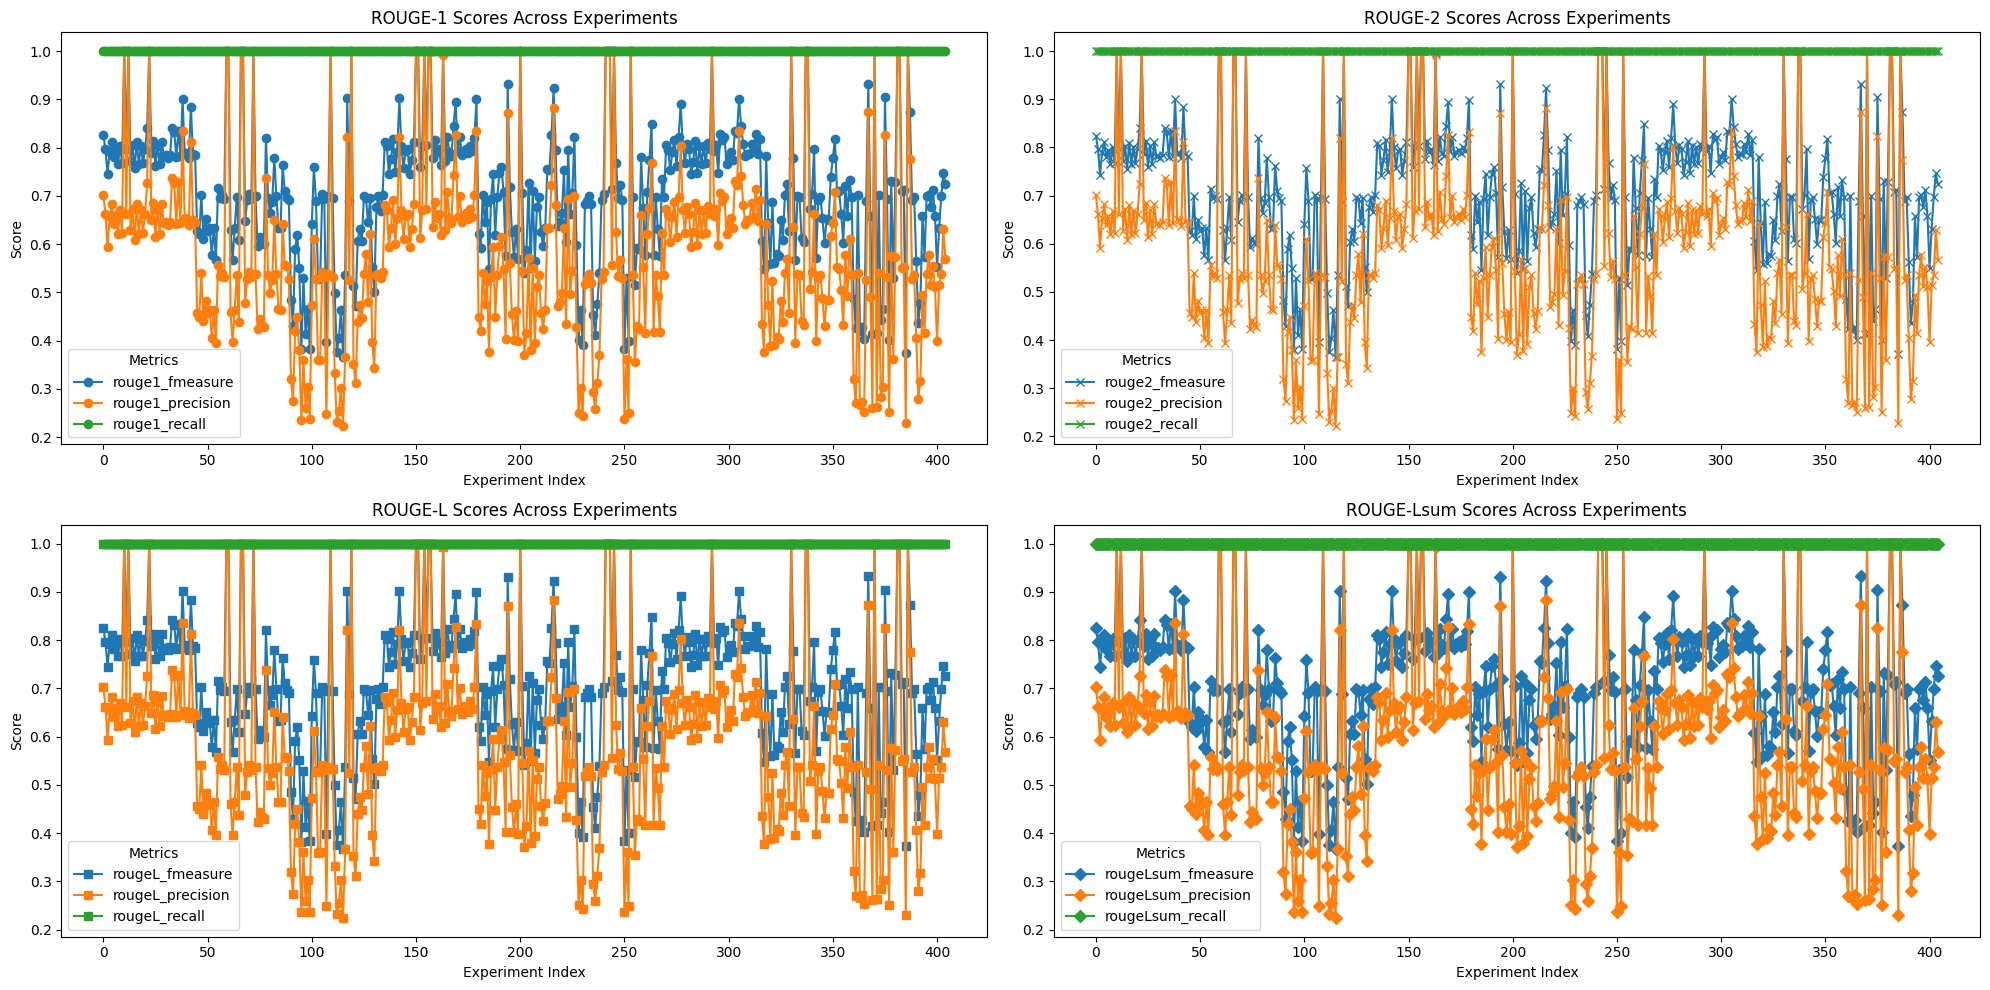

In [6]:
plt.figure(figsize=(20, 10))

# ROUGE-1
plt.subplot(2, 2, 1)
df[['rouge1_fmeasure', 'rouge1_precision', 'rouge1_recall']].plot(ax=plt.gca(), marker='o')
plt.title("ROUGE-1 Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# ROUGE-2
plt.subplot(2, 2, 2)
df[['rouge2_fmeasure', 'rouge2_precision', 'rouge2_recall']].plot(ax=plt.gca(), marker='x')
plt.title("ROUGE-2 Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# ROUGE-L
plt.subplot(2, 2, 3)
df[['rougeL_fmeasure', 'rougeL_precision', 'rougeL_recall']].plot(ax=plt.gca(), marker='s')
plt.title("ROUGE-L Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# ROUGE-Lsum
plt.subplot(2, 2, 4)
df[['rougeLsum_fmeasure', 'rougeLsum_precision', 'rougeLsum_recall']].plot(ax=plt.gca(), marker='D')
plt.title("ROUGE-Lsum Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# Display the plots
plt.tight_layout()
plt.show()

In [7]:
df['configuration'] = df[['model', 'batch_size', 'max_new_tokens', 'quantization']].astype(str).agg('§'.join, axis=1)
df

,model,batch_size,max_new_tokens,input,raw,output,trimmed_output,score,start_time,end_time,...,rouge2_fmeasure,rouge2_precision,rouge2_recall,rougeL_fmeasure,rougeL_precision,rougeL_recall,rougeLsum_fmeasure,rougeLsum_precision,rougeLsum_recall,configuration
0,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"[' I darted diagonally through the street, reg...","{'rouge1_fmeasure': 0.825, 'rouge1_precision':...",1.732998e+09,1.732998e+09,...,0.8241,0.7009,1.0,0.8250,0.7021,1.0,0.8250,0.7021,1.0,meta-llama/Llama-3.2-1B§1§100§4.0
1,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['If there were any suggestions of Mendelssohn...,['Instruction: Rewrite the given text while ke...,[' If there were any suggestions of Mendelssoh...,"{'rouge1_fmeasure': 0.7968, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,0.7958,0.6608,1.0,0.7968,0.6623,1.0,0.7968,0.6623,1.0,meta-llama/Llama-3.2-1B§1§100§4.0
2,meta-llama/Llama-3.2-1B,1,100,"[""Instruction: Rewrite the given text while ke...","[""Deep Tissue Massage is a form of bodywork th...","[""Instruction: Rewrite the given text while ke...","["" Deep Tissue Massage is a form of bodywork t...","{'rouge1_fmeasure': 0.7449, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,0.7434,0.5915,1.0,0.7449,0.5935,1.0,0.7449,0.5935,1.0,meta-llama/Llama-3.2-1B§1§100§4.0
3,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['The procedure for constructing your resume a...,['Instruction: Rewrite the given text while ke...,['1. A procedure for generating a resume and e...,"{'rouge1_fmeasure': 0.7918, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,0.7907,0.6538,1.0,0.7918,0.6553,1.0,0.7918,0.6553,1.0,meta-llama/Llama-3.2-1B§1§100§4.0
4,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['A. Action of the Board: The Board upon a fin...,['Instruction: Rewrite the given text while ke...,[' A. Action of the Board: The Board upon a fi...,"{'rouge1_fmeasure': 0.8115, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,0.8107,0.6816,1.0,0.8115,0.6828,1.0,0.8115,0.6828,1.0,meta-llama/Llama-3.2-1B§1§100§4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,meta-llama/Llama-3.2-1B,8,500,['Instruction: Rewrite the given text while ke...,['The culture takes its name from the village ...,['Instruction: Rewrite the given text while ke...,"['5,000 BCE – 4,000 BCE; 4,000 BCE – 3,000 BCE...","{'rouge1_fmeasure': 0.5521, 'rouge1_precision'...",1.733010e+09,1.733010e+09,...,0.5505,0.3968,1.0,0.5521,0.3984,1.0,0.5521,0.3984,1.0,meta-llama/Llama-3.2-1B§8§500§16.0
401,meta-llama/Llama-3.2-3B,8,500,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"['', '1. 2. 3. 4. 5. 6. 7. 8. 9. 10. \n\n ...","{'rouge1_fmeasure': 0.6323, 'rouge1_precision'...",1.733010e+09,1.733010e+09,...,0.6311,0.5133,1.0,0.6323,0.5144,1.0,0.6323,0.5144,1.0,meta-llama/Llama-3.2-3B§8§500§16.0
402,meta-llama/Llama-3.2-3B,8,500,['Instruction: Rewrite the given text while ke...,['The culture takes its name from the village ...,['Instruction: Rewrite the given text while ke...,[' The culture takes its name from the village...,"{'rouge1_fmeasure': 0.6989, 'rouge1_precision'...",1.733010e+09,1.733010e+09,...,0.6973,0.5353,1.0,0.6989,0.5371,1.0,0.6989,0.5371,1.0,meta-llama/Llama-3.2-3B§8§500§16.0
403,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"['', '', "" Deep Tissue Massage is a kind of bo...","{'rouge1_fmeasure': 0.7471, 'rouge1_precision'...",1.733010e+09,1.733010e+09,...,0.7460,0.6292,1.0,0.7471,0.6304,1.0,0.7471,0.6304,1.0,meta-llama/Llama-3.1-8B§8§500§16.0


Total number of unique configurations: 81


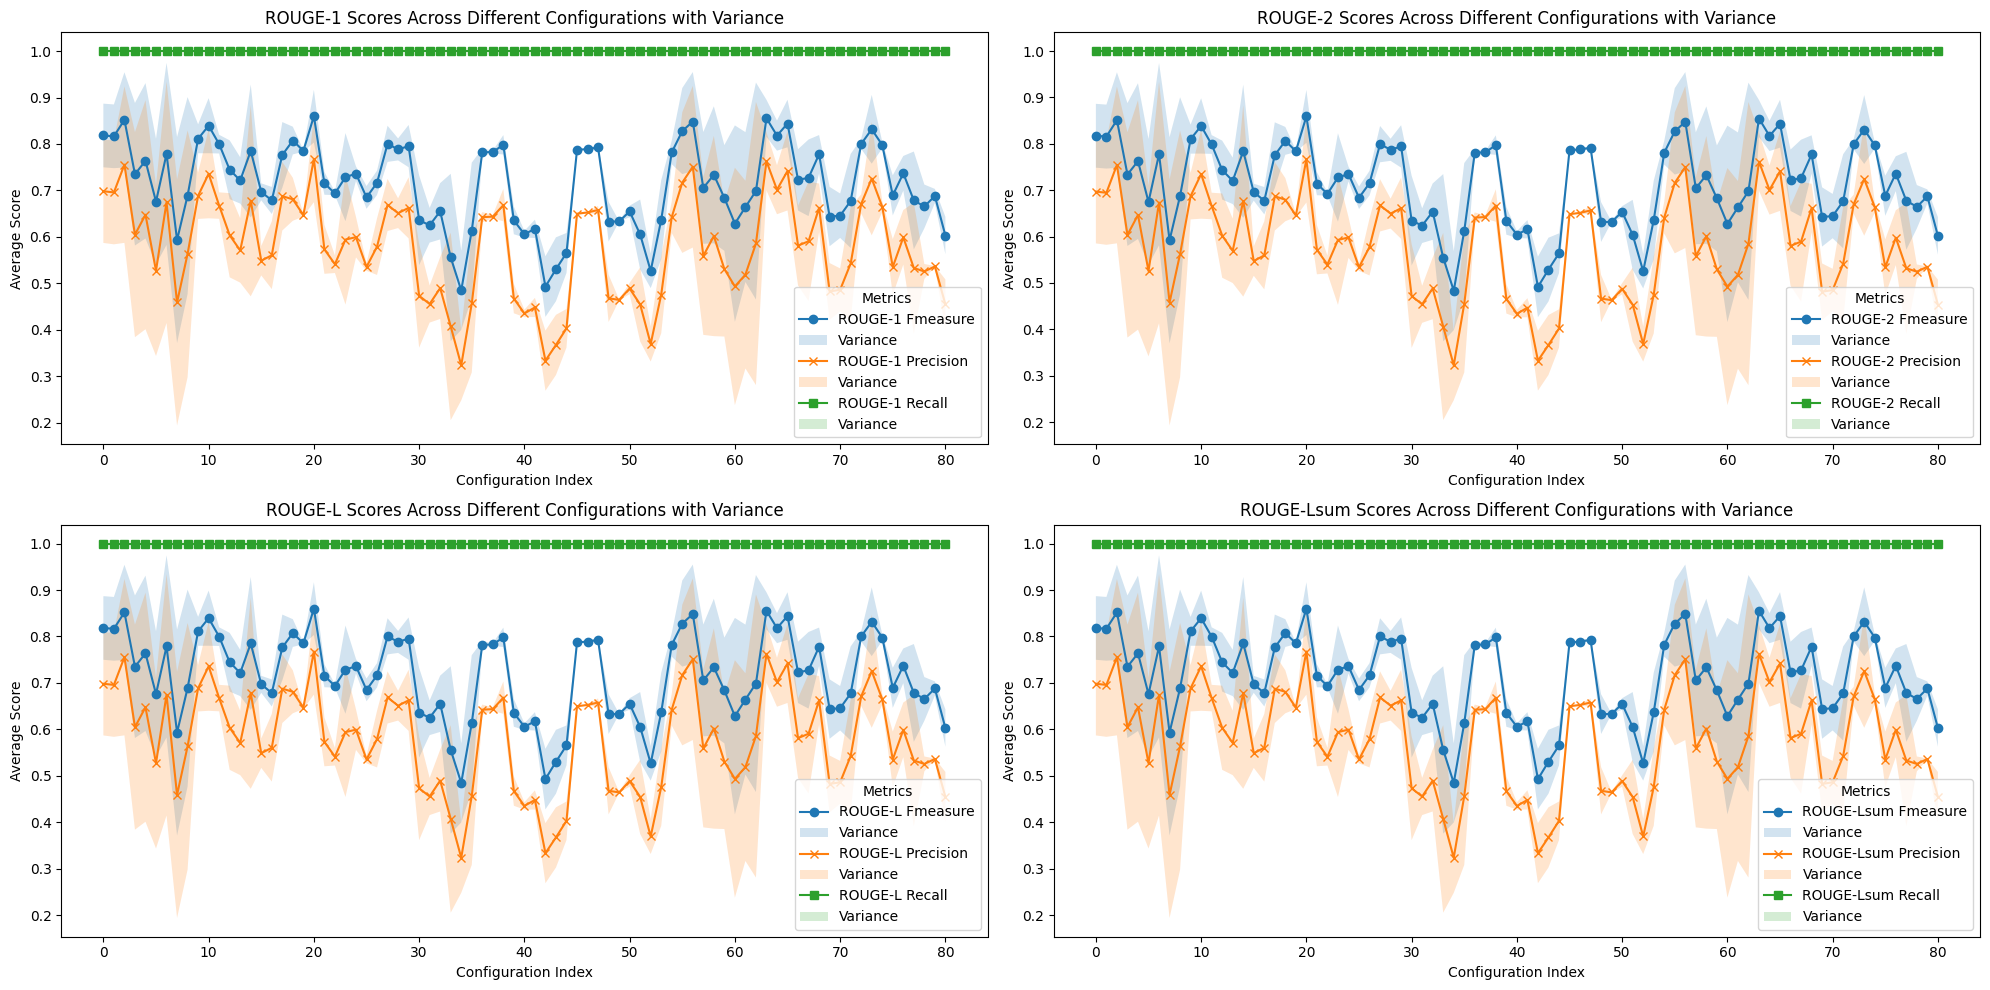

In [8]:
# Group by the complete configuration and calculate the mean and variance
grouped_df = df.groupby('configuration').agg(
    rouge1_fmeasure_mean=('rouge1_fmeasure', 'mean'),
    rouge1_fmeasure_var=('rouge1_fmeasure', 'var'),
    rouge1_precision_mean=('rouge1_precision', 'mean'),
    rouge1_precision_var=('rouge1_precision', 'var'),
    rouge1_recall_mean=('rouge1_recall', 'mean'),
    rouge1_recall_var=('rouge1_recall', 'var'),
    rouge2_fmeasure_mean=('rouge2_fmeasure', 'mean'),
    rouge2_fmeasure_var=('rouge2_fmeasure', 'var'),
    rouge2_precision_mean=('rouge2_precision', 'mean'),
    rouge2_precision_var=('rouge2_precision', 'var'),
    rouge2_recall_mean=('rouge2_recall', 'mean'),
    rouge2_recall_var=('rouge2_recall', 'var'),
    rougeL_fmeasure_mean=('rougeL_fmeasure', 'mean'),
    rougeL_fmeasure_var=('rougeL_fmeasure', 'var'),
    rougeL_precision_mean=('rougeL_precision', 'mean'),
    rougeL_precision_var=('rougeL_precision', 'var'),
    rougeL_recall_mean=('rougeL_recall', 'mean'),
    rougeL_recall_var=('rougeL_recall', 'var'),
    rougeLsum_fmeasure_mean=('rougeLsum_fmeasure', 'mean'),
    rougeLsum_fmeasure_var=('rougeLsum_fmeasure', 'var'),
    rougeLsum_precision_mean=('rougeLsum_precision', 'mean'),
    rougeLsum_precision_var=('rougeLsum_precision', 'var'),
    rougeLsum_recall_mean=('rougeLsum_recall', 'mean'),
    rougeLsum_recall_var=('rougeLsum_recall', 'var'),
).reset_index()

# Make sure the grouping contains 81 configurations by checking the number of unique configurations
print(f"Total number of unique configurations: {grouped_df.shape[0]}")  # This should be 81

plt.figure(figsize=(20, 10))

# ROUGE-1
plt.subplot(2, 2, 1)
plt.plot(grouped_df.index, grouped_df['rouge1_fmeasure_mean'], marker='o', label='ROUGE-1 Fmeasure')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge1_fmeasure_mean'] - grouped_df['rouge1_fmeasure_var']**0.5, 
                 grouped_df['rouge1_fmeasure_mean'] + grouped_df['rouge1_fmeasure_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rouge1_precision_mean'], marker='x', label='ROUGE-1 Precision')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge1_precision_mean'] - grouped_df['rouge1_precision_var']**0.5, 
                 grouped_df['rouge1_precision_mean'] + grouped_df['rouge1_precision_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rouge1_recall_mean'], marker='s', label='ROUGE-1 Recall')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge1_recall_mean'] - grouped_df['rouge1_recall_var']**0.5, 
                 grouped_df['rouge1_recall_mean'] + grouped_df['rouge1_recall_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.title("ROUGE-1 Scores Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Score")
plt.legend(title='Metrics')

# ROUGE-2
plt.subplot(2, 2, 2)
plt.plot(grouped_df.index, grouped_df['rouge2_fmeasure_mean'], marker='o', label='ROUGE-2 Fmeasure')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge2_fmeasure_mean'] - grouped_df['rouge2_fmeasure_var']**0.5, 
                 grouped_df['rouge2_fmeasure_mean'] + grouped_df['rouge2_fmeasure_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rouge2_precision_mean'], marker='x', label='ROUGE-2 Precision')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge2_precision_mean'] - grouped_df['rouge2_precision_var']**0.5, 
                 grouped_df['rouge2_precision_mean'] + grouped_df['rouge2_precision_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rouge2_recall_mean'], marker='s', label='ROUGE-2 Recall')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge2_recall_mean'] - grouped_df['rouge2_recall_var']**0.5, 
                 grouped_df['rouge2_recall_mean'] + grouped_df['rouge2_recall_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.title("ROUGE-2 Scores Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Score")
plt.legend(title='Metrics')

# ROUGE-L
plt.subplot(2, 2, 3)
plt.plot(grouped_df.index, grouped_df['rougeL_fmeasure_mean'], marker='o', label='ROUGE-L Fmeasure')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeL_fmeasure_mean'] - grouped_df['rougeL_fmeasure_var']**0.5, 
                 grouped_df['rougeL_fmeasure_mean'] + grouped_df['rougeL_fmeasure_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rougeL_precision_mean'], marker='x', label='ROUGE-L Precision')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeL_precision_mean'] - grouped_df['rougeL_precision_var']**0.5, 
                 grouped_df['rougeL_precision_mean'] + grouped_df['rougeL_precision_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rougeL_recall_mean'], marker='s', label='ROUGE-L Recall')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeL_recall_mean'] - grouped_df['rougeL_recall_var']**0.5,
                    grouped_df['rougeL_recall_mean'] + grouped_df['rougeL_recall_var']**0.5,
                    alpha=0.2, label='Variance')
plt.title("ROUGE-L Scores Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Score")
plt.legend(title='Metrics')

# ROUGE-Lsum
plt.subplot(2, 2, 4)
plt.plot(grouped_df.index, grouped_df['rougeLsum_fmeasure_mean'], marker='o', label='ROUGE-Lsum Fmeasure')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeLsum_fmeasure_mean'] - grouped_df['rougeLsum_fmeasure_var']**0.5, 
                 grouped_df['rougeLsum_fmeasure_mean'] + grouped_df['rougeLsum_fmeasure_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rougeLsum_precision_mean'], marker='x', label='ROUGE-Lsum Precision')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeLsum_precision_mean'] - grouped_df['rougeLsum_precision_var']**0.5, 
                 grouped_df['rougeLsum_precision_mean'] + grouped_df['rougeLsum_precision_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rougeLsum_recall_mean'], marker='s', label='ROUGE-Lsum Recall')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeLsum_recall_mean'] - grouped_df['rougeLsum_recall_var']**0.5, 
                 grouped_df['rougeLsum_recall_mean'] + grouped_df['rougeLsum_recall_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.title("ROUGE-Lsum Scores Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Score")
plt.legend(title='Metrics')

# Display the plots
plt.tight_layout()

In [9]:
grouped_df

,configuration,rouge1_fmeasure_mean,rouge1_fmeasure_var,rouge1_precision_mean,rouge1_precision_var,rouge1_recall_mean,rouge1_recall_var,rouge2_fmeasure_mean,rouge2_fmeasure_var,rouge2_precision_mean,...,rougeL_precision_mean,rougeL_precision_var,rougeL_recall_mean,rougeL_recall_var,rougeLsum_fmeasure_mean,rougeLsum_fmeasure_var,rougeLsum_precision_mean,rougeLsum_precision_var,rougeLsum_recall_mean,rougeLsum_recall_var
0,meta-llama/Llama-3.1-8B§1§100§16.0,0.81835,0.004690,0.69833,1.237583e-02,1.0,0.0,0.81737,0.004742,0.69698,...,0.69833,1.237583e-02,1.0,0.0,0.81835,0.004690,0.69833,1.237583e-02,1.0,0.0
1,meta-llama/Llama-3.1-8B§1§100§4.0,0.81656,0.004701,0.69582,1.247975e-02,1.0,0.0,0.81557,0.004754,0.69446,...,0.69582,1.247975e-02,1.0,0.0,0.81656,0.004701,0.69582,1.247975e-02,1.0,0.0
2,meta-llama/Llama-3.1-8B§1§100§8.0,0.85188,0.010498,0.75553,2.831671e-02,1.0,0.0,0.85108,0.010615,0.75444,...,0.75553,2.831671e-02,1.0,0.0,0.85188,0.010498,0.75553,2.831671e-02,1.0,0.0
3,meta-llama/Llama-3.1-8B§1§250§16.0,0.73497,0.023530,0.60500,4.871330e-02,1.0,0.0,0.73379,0.023720,0.60366,...,0.60500,4.871330e-02,1.0,0.0,0.73497,0.023530,0.60500,4.871330e-02,1.0,0.0
4,meta-llama/Llama-3.1-8B§1§250§4.0,0.76380,0.027943,0.64780,6.073431e-02,1.0,0.0,0.76273,0.028189,0.64661,...,0.64780,6.073431e-02,1.0,0.0,0.76380,0.027943,0.64780,6.073431e-02,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,meta-llama/Llama-3.2-3B§8§250§4.0,0.73690,0.001394,0.59915,3.452805e-03,1.0,0.0,0.73565,0.001410,0.59760,...,0.59915,3.452805e-03,1.0,0.0,0.73690,0.001394,0.59915,3.452805e-03,1.0,0.0
77,meta-llama/Llama-3.2-3B§8§250§8.0,0.67860,0.011071,0.53310,1.984032e-02,1.0,0.0,0.67715,0.011145,0.53155,...,0.53310,1.984032e-02,1.0,0.0,0.67860,0.011071,0.53310,1.984032e-02,1.0,0.0
78,meta-llama/Llama-3.2-3B§8§500§16.0,0.66560,0.002218,0.52575,2.576450e-04,1.0,0.0,0.66420,0.002191,0.52430,...,0.52575,2.576450e-04,1.0,0.0,0.66560,0.002218,0.52575,2.576450e-04,1.0,0.0
79,meta-llama/Llama-3.2-3B§8§500§4.0,0.68810,0.000233,0.53645,8.450000e-07,1.0,0.0,0.68665,0.000227,0.53485,...,0.53645,8.450000e-07,1.0,0.0,0.68810,0.000233,0.53645,8.450000e-07,1.0,0.0


Total number of unique configurations: 81


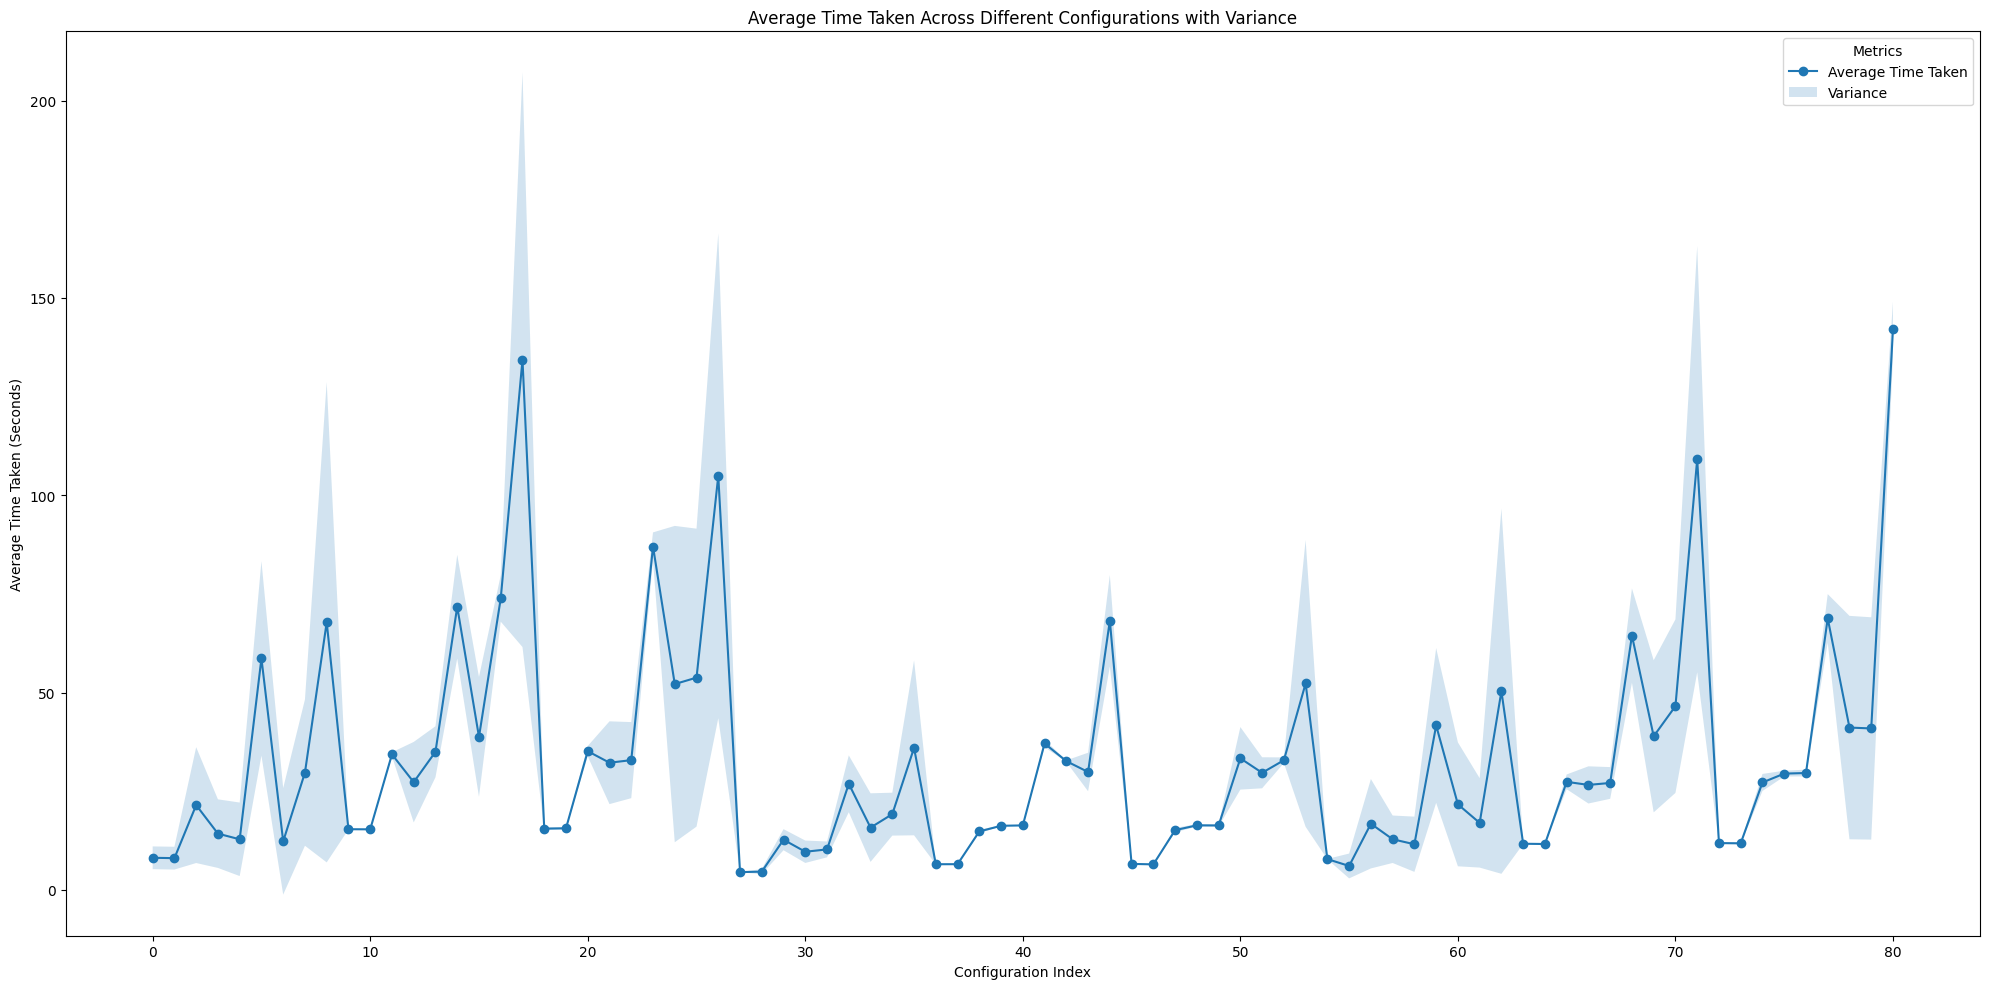

In [10]:
# Group by configuration and calculate the mean and variance for 'time_taken'
grouped_time_df = df.groupby('configuration').agg(
    time_taken_mean=('time_taken', 'mean'),
    time_taken_var=('time_taken', 'var')
).reset_index()

# Make sure the grouping contains the expected number of configurations
print(f"Total number of unique configurations: {grouped_time_df.shape[0]}")  # This should match the expected count (e.g., 81)

# Plotting the 'time_taken' values along with the variance
plt.figure(figsize=(20, 10))

# Plot the average 'time_taken' with error bars for variance
plt.plot(grouped_time_df.index, grouped_time_df['time_taken_mean'], marker='o', label='Average Time Taken')
plt.fill_between(grouped_time_df.index, 
                 grouped_time_df['time_taken_mean'] - grouped_time_df['time_taken_var']**0.5, 
                 grouped_time_df['time_taken_mean'] + grouped_time_df['time_taken_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.title("Average Time Taken Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Time Taken (Seconds)")
plt.legend(title='Metrics')

# Display the plot
plt.tight_layout()
plt.show()

In [11]:
print(grouped_df.columns)

Index(['configuration', 'rouge1_fmeasure_mean', 'rouge1_fmeasure_var',
       'rouge1_precision_mean', 'rouge1_precision_var', 'rouge1_recall_mean',
       'rouge1_recall_var', 'rouge2_fmeasure_mean', 'rouge2_fmeasure_var',
       'rouge2_precision_mean', 'rouge2_precision_var', 'rouge2_recall_mean',
       'rouge2_recall_var', 'rougeL_fmeasure_mean', 'rougeL_fmeasure_var',
       'rougeL_precision_mean', 'rougeL_precision_var', 'rougeL_recall_mean',
       'rougeL_recall_var', 'rougeLsum_fmeasure_mean',
       'rougeLsum_fmeasure_var', 'rougeLsum_precision_mean',
       'rougeLsum_precision_var', 'rougeLsum_recall_mean',
       'rougeLsum_recall_var'],
      dtype='object')


In [12]:
# Split the 'configuration' column into parts
grouped_df[['model', 'batch_size', 'max_new_tokens', 'quantization']] = grouped_df['configuration'].str.split('§', expand=True)
grouped_time_df[['model', 'batch_size', 'max_new_tokens', 'quantization']] = grouped_time_df['configuration'].str.split('§', expand=True)
# Check the first few rows of the new columns
#print(grouped_df[['model', 'batch_size', 'max_new_tokens', 'quantization']].head())
grouped_time_df

,configuration,time_taken_mean,time_taken_var,model,batch_size,max_new_tokens,quantization
0,meta-llama/Llama-3.1-8B§1§100§16.0,8.142230,8.301968,meta-llama/Llama-3.1-8B,1,100,16.0
1,meta-llama/Llama-3.1-8B§1§100§4.0,8.047086,8.336668,meta-llama/Llama-3.1-8B,1,100,4.0
2,meta-llama/Llama-3.1-8B§1§100§8.0,21.490215,215.405991,meta-llama/Llama-3.1-8B,1,100,8.0
3,meta-llama/Llama-3.1-8B§1§250§16.0,14.262098,75.518278,meta-llama/Llama-3.1-8B,1,250,16.0
4,meta-llama/Llama-3.1-8B§1§250§4.0,12.825520,86.733206,meta-llama/Llama-3.1-8B,1,250,4.0
...,...,...,...,...,...,...,...
76,meta-llama/Llama-3.2-3B§8§250§4.0,29.618373,0.738359,meta-llama/Llama-3.2-3B,8,250,4.0
77,meta-llama/Llama-3.2-3B§8§250§8.0,68.798792,37.862073,meta-llama/Llama-3.2-3B,8,250,8.0
78,meta-llama/Llama-3.2-3B§8§500§16.0,41.136829,801.129158,meta-llama/Llama-3.2-3B,8,500,16.0
79,meta-llama/Llama-3.2-3B§8§500§4.0,40.914742,793.270409,meta-llama/Llama-3.2-3B,8,500,4.0


In [ ]:
# Temporarily convert 'quantization' to float to fill NaN values
grouped_df['quantization'] = grouped_df['quantization'].astype('float')

# If you want to convert it back to categorical, add 0.0 to categories
grouped_df['quantization'] = grouped_df['quantization'].astype('category')

# Verify the result
print(grouped_df.head())

                        configuration  rouge1_fmeasure_mean  \
0  meta-llama/Llama-3.1-8B§1§100§16.0               0.81835   
1   meta-llama/Llama-3.1-8B§1§100§4.0               0.81656   
2   meta-llama/Llama-3.1-8B§1§100§8.0               0.85188   
3  meta-llama/Llama-3.1-8B§1§250§16.0               0.73497   
4   meta-llama/Llama-3.1-8B§1§250§4.0               0.76380   

   rouge1_fmeasure_var  rouge1_precision_mean  rouge1_precision_var  \
0             0.004690                0.69833              0.012376   
1             0.004701                0.69582              0.012480   
2             0.010498                0.75553              0.028317   
3             0.023530                0.60500              0.048713   
4             0.027943                0.64780              0.060734   

   rouge1_recall_mean  rouge1_recall_var  rouge2_fmeasure_mean  \
0                 1.0                0.0               0.81737   
1                 1.0                0.0               0.81557

In [ ]:
# Perform two-way ANOVA on 'time_taken'
model_time_taken = ols('time_taken_mean ~ C(model) + C(batch_size) + C(max_new_tokens) + C(quantization)', data=grouped_time_df).fit()
anova_table_time_taken = sm.stats.anova_lm(model_time_taken, typ=2)

# Display ANOVA results for time_taken
print("ANOVA Results for Time Taken:")
print(anova_table_time_taken)

# Perform two-way ANOVA on 'rouge1_fmeasure_mean'
model_rouge1_fmeasure = ols('rouge1_fmeasure_mean ~ C(model) + C(batch_size) + C(max_new_tokens) + C(quantization)', data=grouped_df).fit()
anova_table_rouge1_fmeasure = sm.stats.anova_lm(model_rouge1_fmeasure, typ=2)

# Display ANOVA results for rouge1_fmeasure
print("\nANOVA Results for ROUGE-1 F-measure:")
print(anova_table_rouge1_fmeasure)

# Perform two-way ANOVA on 'rouge2_fmeasure_mean'
model_rouge2_fmeasure = ols('rouge2_fmeasure_mean ~ C(model) + C(batch_size) + C(max_new_tokens) + C(quantization)', data=grouped_df).fit()
anova_table_rouge2_fmeasure = sm.stats.anova_lm(model_rouge2_fmeasure, typ=2)

# Display ANOVA results for rouge2_fmeasure
print("\nANOVA Results for ROUGE-2 F-measure:")
print(anova_table_rouge2_fmeasure)

# Perform two-way ANOVA on 'rougeL_fmeasure_mean'
model_rougeL_fmeasure = ols('rougeL_fmeasure_mean ~ C(model) + C(batch_size) + C(max_new_tokens) + C(quantization)', data=grouped_df).fit()
anova_table_rougeL_fmeasure = sm.stats.anova_lm(model_rougeL_fmeasure, typ=2)

# Display ANOVA results for rougeL_fmeasure
print("\nANOVA Results for ROUGE-L F-measure:")
print(anova_table_rougeL_fmeasure)

# Perform two-way ANOVA on 'rougeLsum_fmeasure_mean'
model_rougeLsum_fmeasure = ols('rougeLsum_fmeasure_mean ~ C(model) + C(batch_size) + C(max_new_tokens) + C(quantization)', data=grouped_df).fit()
anova_table_rougeLsum_fmeasure = sm.stats.anova_lm(model_rougeLsum_fmeasure, typ=2)

# Display ANOVA results for rougeLsum_fmeasure
print("\nANOVA Results for ROUGE-Lsum F-measure:")
print(anova_table_rougeLsum_fmeasure)

                            OLS Regression Results                            
Dep. Variable:        time_taken_mean   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     30.69
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           2.74e-20
Time:                        09:50:48   Log-Likelihood:                -324.71
No. Observations:                  81   AIC:                             667.4
Df Residuals:                      72   BIC:                             689.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

### ANOVA Results for Time Taken:

| Factor              | Sum of Squares | Degrees of Freedom (df) | F-value  | P-value     |
|---------------------|----------------|--------------------------|----------|-------------|
| Model               | 5529.10        | 2                        | 13.83    | 0.000008    |
| Batch Size          | 0.0003         | 2                        | 0.11     | 0.90        |
| Max New Tokens      | 0.41           | 2                        | 135.75   | 0.000000000000000000000037 |
| Quantization        | 0.0069         | 2                        | 2.24     | 0.11        |
| Residual            | 0.11           | 72                       | -        | -           |
